# Project Overview


Credit card fraud poses a significant challenge, and rapid detection is critical. While many machine learning models use supervised learning, anomaly detection can often be more effective for fraud detection, as fraudulent transactions are rare and the amount of labeled data available is usually limited. In contrast, anomaly detection doesn’t require numerous fraudulent samples and can identify suspicious transactions based on how much they deviate from typical patterns.<br>

This project will utilize three anomaly detection algorithms—Isolation Forest, One-Class SVM, and Autoencoders—to identify potentially fraudulent transactions. i'll pick the model that best meets the demand

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout  
from tensorflow.keras.regularizers import l2 

palette = ['#00777F', '#5BABF5', '#AADEFE', '#EAAC9F', '#8AA0AF']
sns.set_theme(context='notebook', palette=palette, style='darkgrid')

# Suppress the FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
raw_data = pd.read_csv('creditcard.csv')
df = raw_data.copy()
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
#the target feature is the class varivable in the data
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

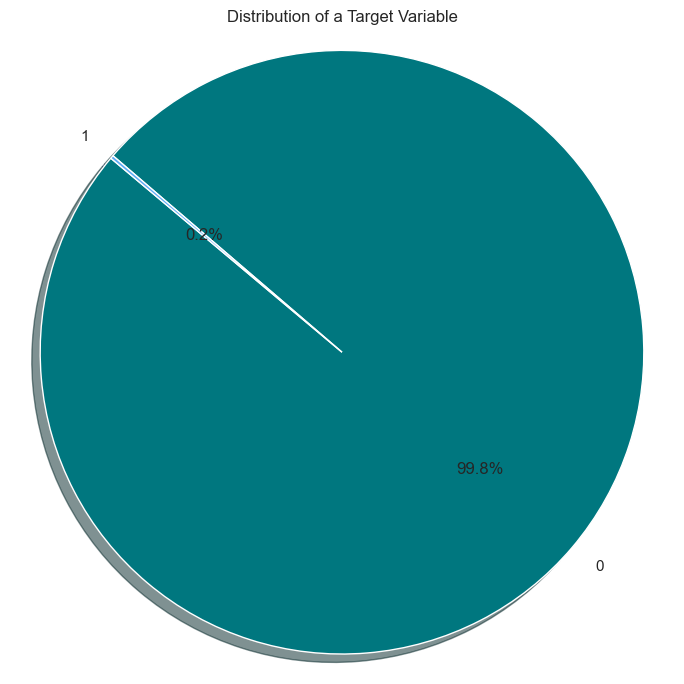

In [6]:
#creating a pie chart to visuallize the class  variiable in the dataset
transaction_status = df.Class.value_counts()\

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(transaction_status, labels=transaction_status.index, autopct='%1.1f%%', 
        startangle=140, colors=palette, shadow=True)

plt.title('Distribution of a Target Variable')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

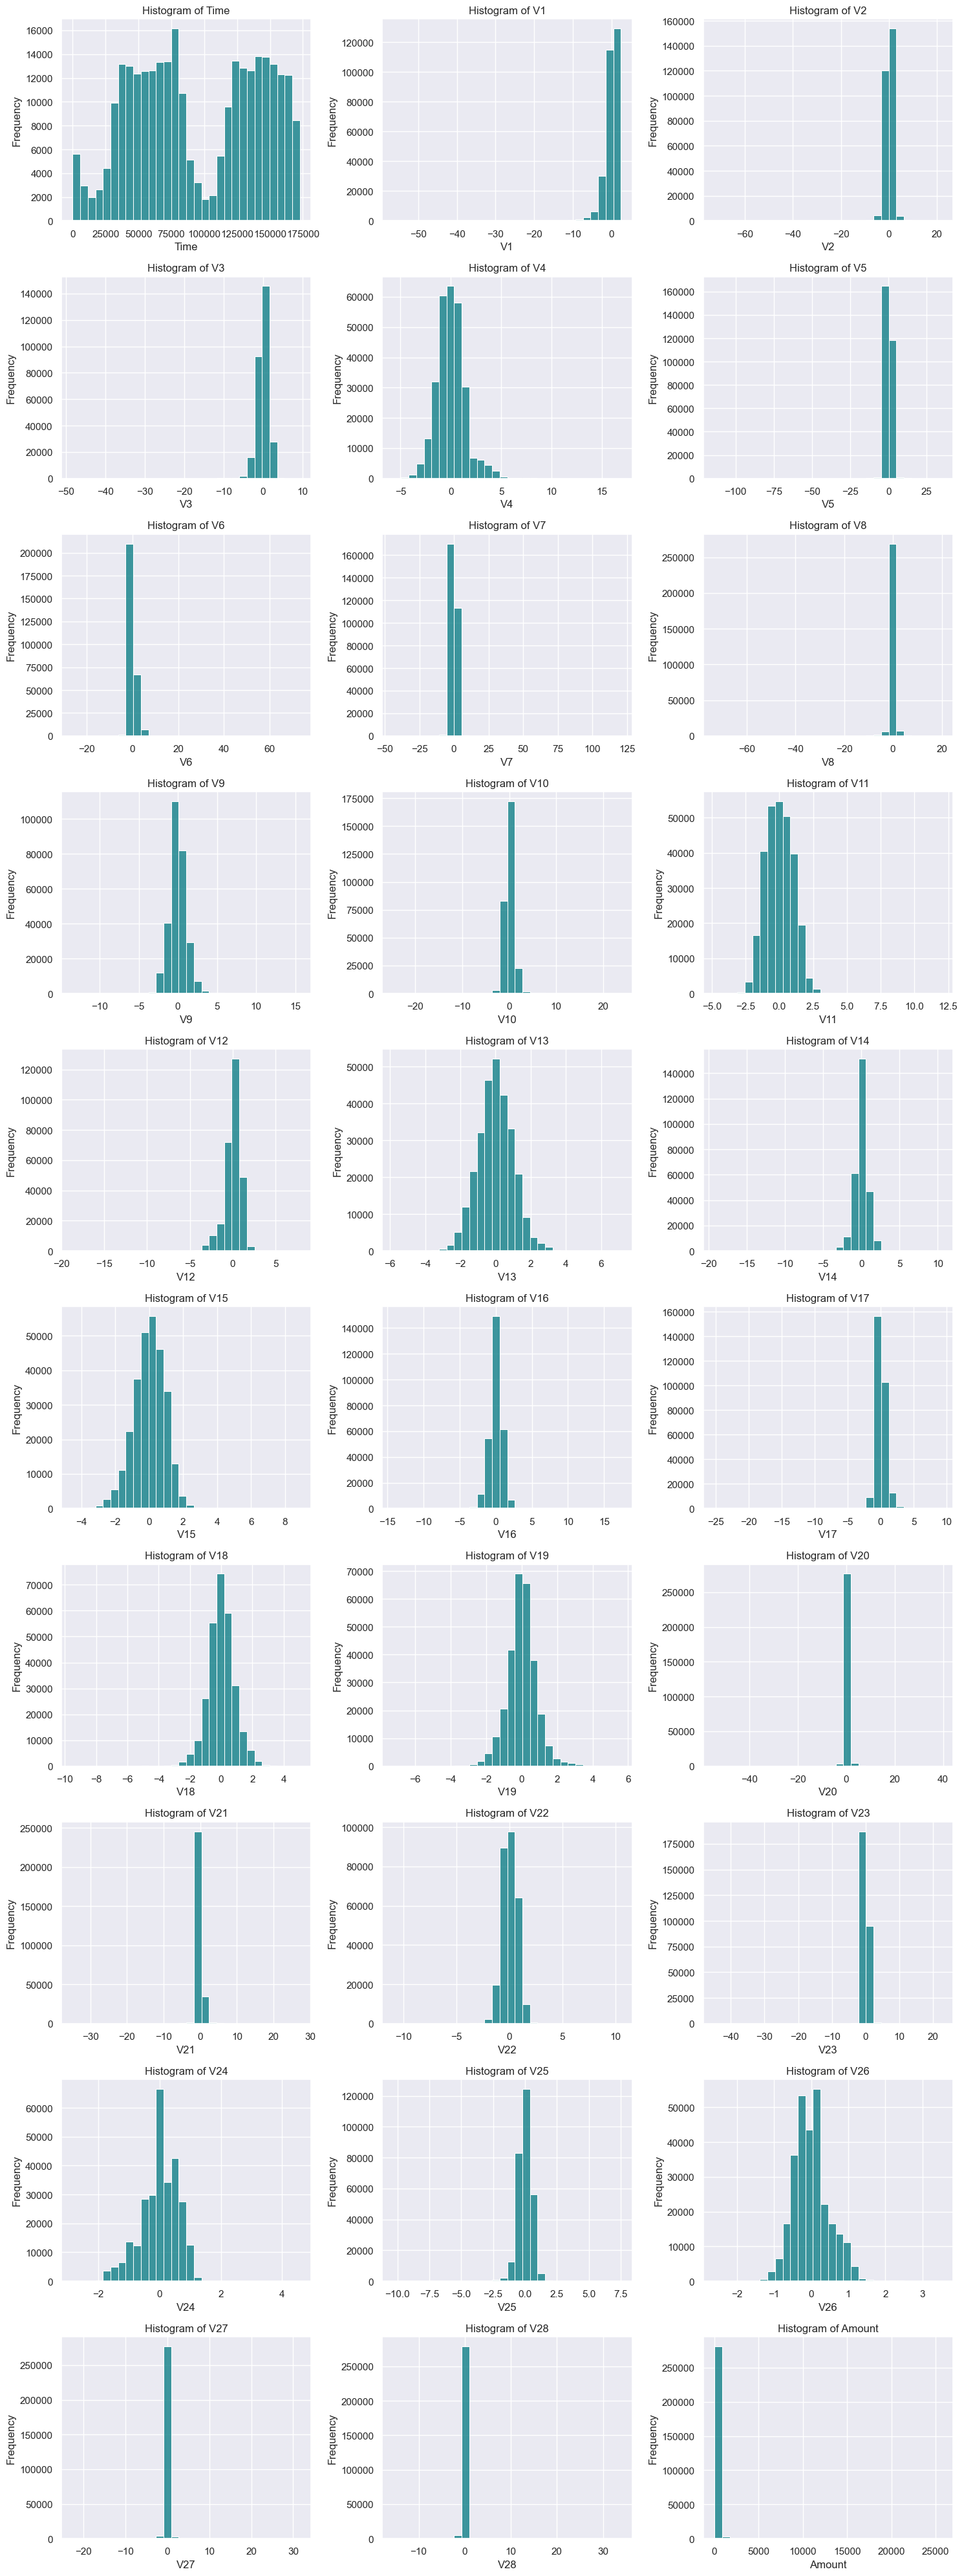

In [7]:
# Feature names
features = df.columns[:-1]

# Set up the figure; 10 rows (10*3=30 subplots), adjust as needed
fig, axes = plt.subplots(10, 3, figsize=(15, 40))  # Adjust rows to fit all features

# Flatten axes array to loop through easily
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    sns.histplot(df[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if features < 30
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [8]:
transformed_df = df.copy()

def log_transform_skew(col):
    transformed = np.where(col >= 0, np.log1p(col), -np.log1p(-col))
    return transformed


for col in features:
    if abs(df[col].skew() > 0.75):
        transformed_df[col] = log_transform_skew(df[col])


df_skewness = df.skew() # skewness of the dataset before log transformation
transformed_df_skewness = transformed_df.skew() # skewness of dataset after log transformation


skewness_comparison = pd.DataFrame({'old skewness':df_skewness, 'new skewness':transformed_df_skewness})
skewness_comparison

C:\Users\001\Documents\workbench\myenv\myprojectsspace\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\001\Documents\workbench\myenv\myprojectsspace\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,old skewness,new skewness
Time,-0.035568,-0.035568
V1,-3.280667,-3.280667
V2,-4.624866,-4.624866
V3,-2.240155,-2.240155
V4,0.676292,0.676292
V5,-2.425901,-2.425901
V6,1.826581,0.804345
V7,2.553907,-0.112666
V8,-8.521944,-8.521944
V9,0.554680,0.554680


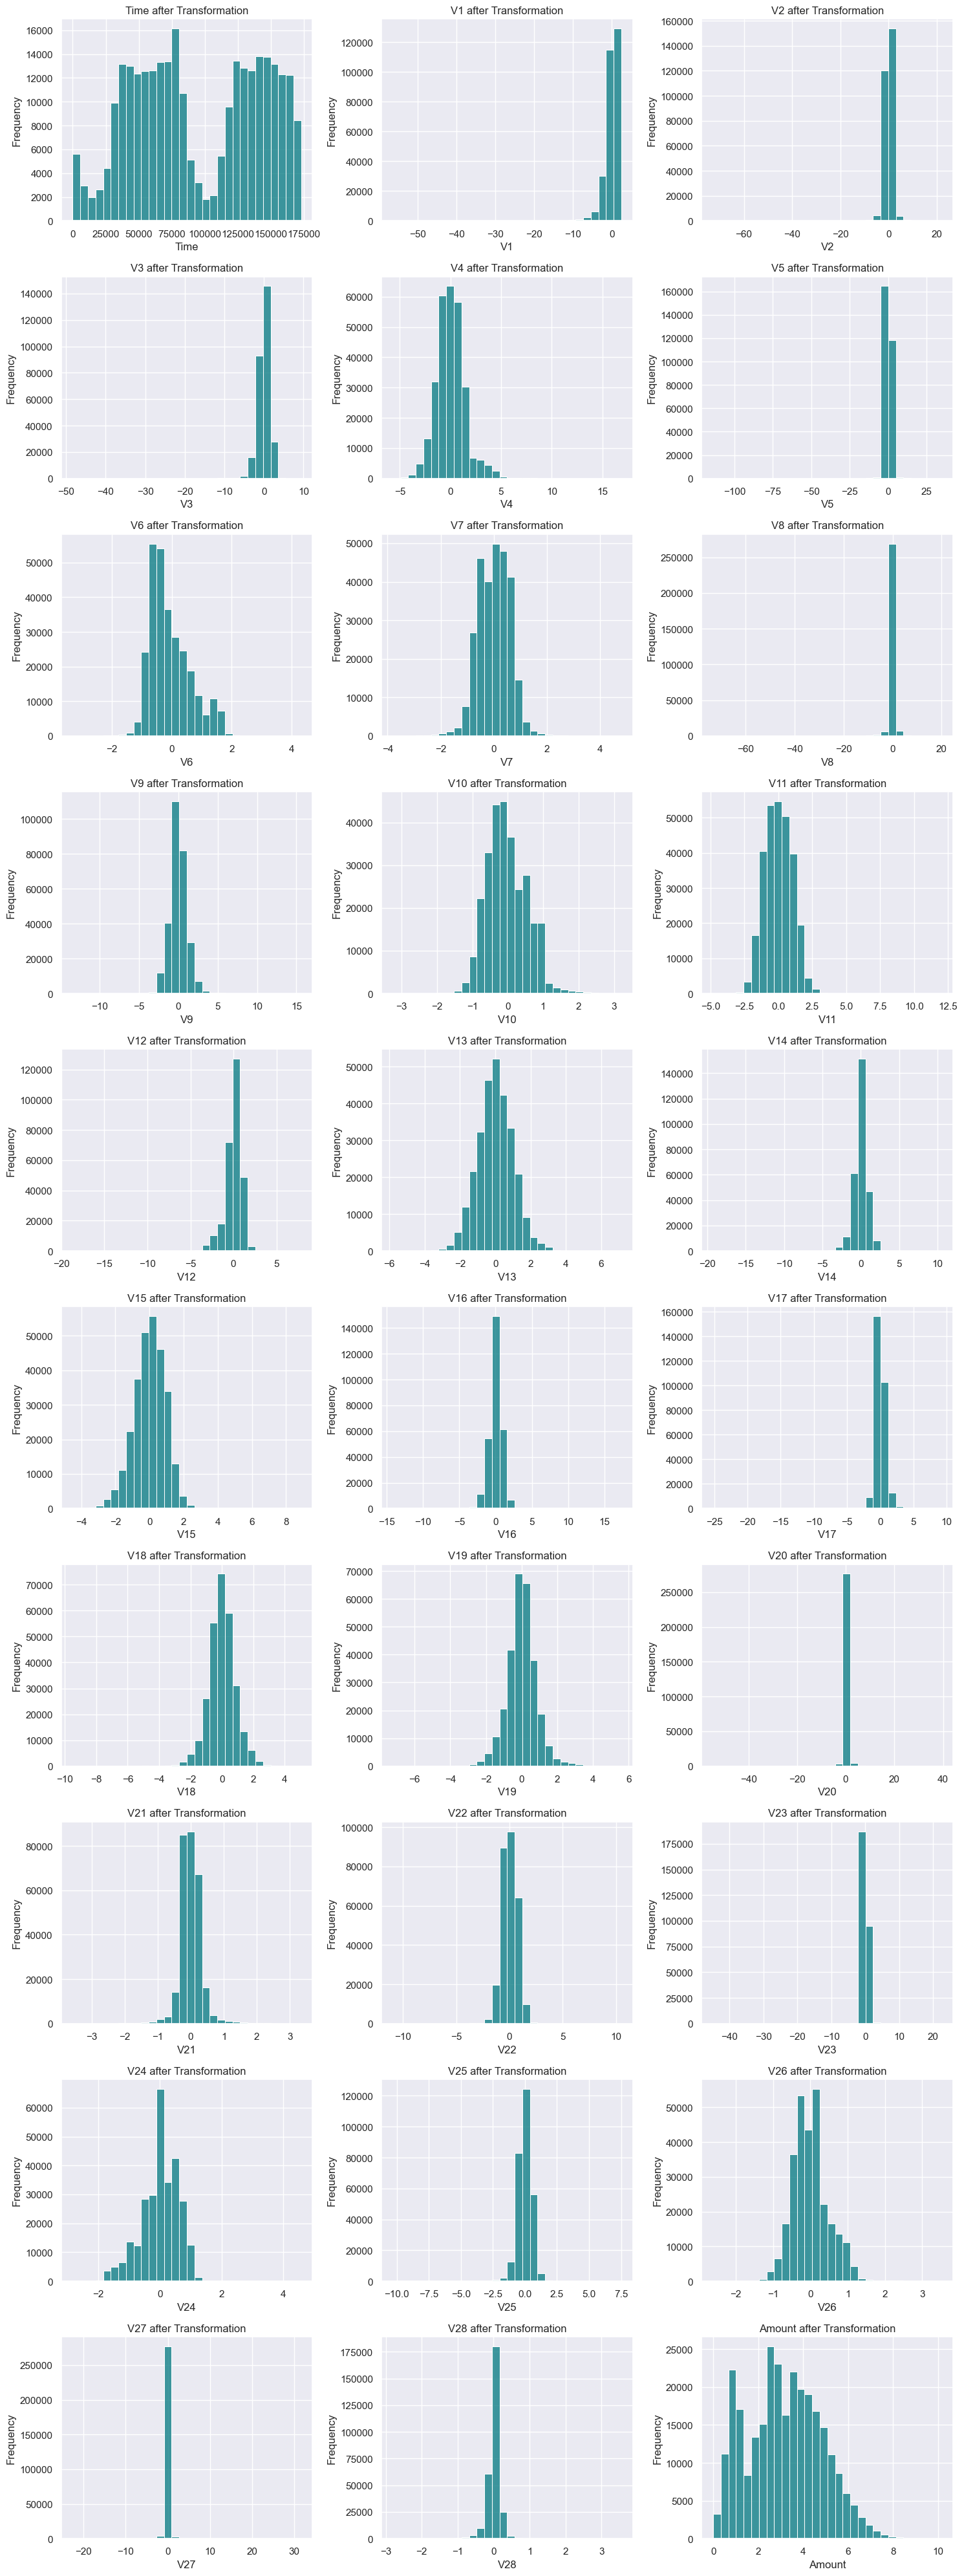

In [9]:
# Set up the figure; 10 rows (10*3=30 subplots), adjust as needed
fig, axes = plt.subplots(10, 3, figsize=(15, 40))  # Adjust rows to fit all features

# Flatten axes array to loop through easily
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    sns.histplot(transformed_df[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'{feature} after Transformation')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if features < 30
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [10]:
# Separate features and target
inputs = transformed_df[features]
targets = transformed_df.Class

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(inputs)

# Building The Model Using Isolation Forest

In [11]:
# Initialize the Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=101)   # high contamination in order to catch more fraudulent transactions

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
iso_preds = iso_forest.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]

# Evaluate the results
print(classification_report(targets, iso_preds))
roc_auc = roc_auc_score(targets, iso_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.86      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9035414994733455


# Confustion matrix

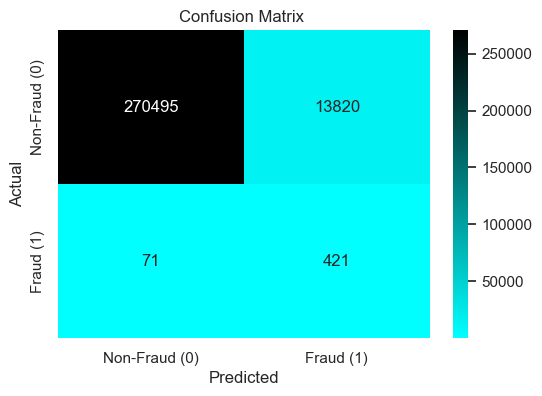

In [12]:
# Custom color palette
colors = ['cyan', 'black']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Plotting the confusion matrix
cm = confusion_matrix(targets, iso_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

# Building The Model Using One-class SVM

In [13]:
# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
svm_preds = oc_svm.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
svm_preds = [1 if x == -1 else 0 for x in svm_preds]

# Evaluate the results
print(classification_report(targets, svm_preds))
roc_auc = roc_auc_score(targets, svm_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    284315
           1       0.03      0.88      0.06       492

    accuracy                           0.95    284807
   macro avg       0.52      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9137234458402301
Confusion Matrix:


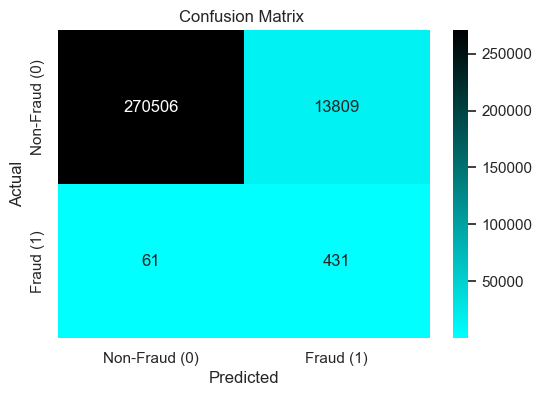

In [15]:
# Plotting the confusion matrix
cm = confusion_matrix(targets, svm_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [20]:
# Defining the autoencoder model
def autoencoder_model(input_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(encoded)
    encoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(encoded)
    
    # Latent space
    latent = Dense(4, activation='relu')(encoded)
    
    # Decoder
    decoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(latent)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    decoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

# Building and compiling the model
autoencoder = autoencoder_model(X_scaled.shape[1])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Training the model on normal transactions (non-fraudulent class, targets == 0)
X_train = X_scaled[targets == 0]
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

# Calculating the reconstruction error for all transactions
reconstructed = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)  # Adjusting threshold (90th percentile)
autoen_preds = np.where(mse > threshold, 1, 0)  # 1: anomaly (fraud), 0: normal

# Evaluating the model performance
print(classification_report(targets, autoen_preds))
roc_auc = roc_auc_score(targets, autoen_preds)
print("ROC AUC Score: ", roc_auc)

Epoch 1/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 1.0012 - val_loss: 0.9238
Epoch 2/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8966 - val_loss: 0.8937
Epoch 3/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8795 - val_loss: 0.8621
Epoch 4/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8533 - val_loss: 0.8307
Epoch 5/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8358 - val_loss: 0.8177
Epoch 6/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8403 - val_loss: 0.8087
Epoch 7/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8301 - val_loss: 0.8051
Epoch 8/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8234 - val_loss: 0.8028
Epoch 9/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8191 - val_loss: 0.7994
Epoch 10/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8132 - val_loss: 0.8005
Epoch 11/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.8151 - val_loss: 0.7984
Epoch 12/50
7997/7997 ━━━━━━━

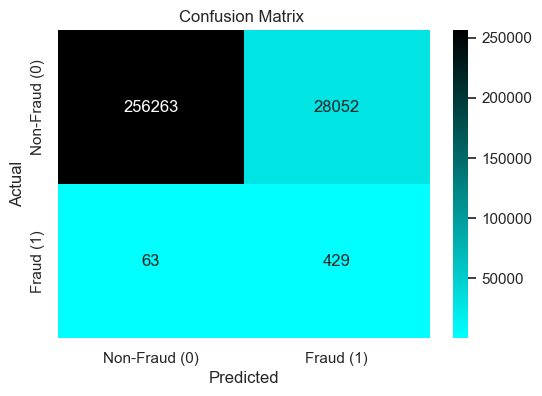

In [18]:
# Plotting the confusion matrix
cm = confusion_matrix(targets, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()